In [1]:
import numpy as np
import os 
from tqdm import tqdm 
from torchvision.transforms.functional import rgb_to_grayscale
import skimage
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import cv2 
import matplotlib.pyplot as plt

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import cv2
import plotly.express as px
from bcss_dataset_preprocess import mergeClass, cropROI, splitImg
from skimage.filters.rank import majority, median
from skimage.morphology import disk

In [15]:
origin_dir = '../dataset2d/CRAG'
traimgs_dir = os.path.join(origin_dir, 'train/Images/')
trasegs_dir = os.path.join(origin_dir, 'train/Annotation/')
valimgs_dir = os.path.join(origin_dir, 'valid/Images/')
valsegs_dir = os.path.join(origin_dir, 'valid/Annotation/')

imgs = []
segs = []

tra_nms = sorted(['.'.join(nm.split('.')[:-1]) for nm in os.listdir(traimgs_dir)])
val_nms = sorted(['.'.join(nm.split('.')[:-1]) for nm in os.listdir(valimgs_dir)])

for nm in tra_nms:
    img_path = os.path.join(traimgs_dir, nm + '.png')
    seg_path = os.path.join(trasegs_dir, nm + '.png')

    if os.path.isfile(img_path) & os.path.isfile(seg_path):
        imgs.append(img_path)
        segs.append(seg_path)

for nm in val_nms:
    img_path = os.path.join(valimgs_dir, nm + '.png')
    seg_path = os.path.join(valsegs_dir, nm + '.png')

    if os.path.isfile(img_path) & os.path.isfile(seg_path):
        imgs.append(img_path)
        segs.append(seg_path)

files = [{"image": img, "label": seg} for img, seg in zip(imgs, segs)]

In [17]:
labels = []
for idx, sample in tqdm(enumerate(files), total=len(files)):
    img_path = sample['image']
    label_path = sample['label']
    img = Image.open(img_path)
    label = Image.open(label_path)

    img = np.array(img)
    label = np.array(label)

    if len(img.shape) == 2:
        img = skimage.color.gray2rgb(img)
        print('gray image : ', img_path)
    
    if (len(img.shape) == 3) & (img.shape[-1] == 4):
        img = skimage.color.rgba2rgb(img)
        img = (img * 255).astype(np.uint8)
        print("rgba image : ", img_path)

    labels.append(label)

100%|██████████| 213/213 [00:36<00:00,  5.84it/s]


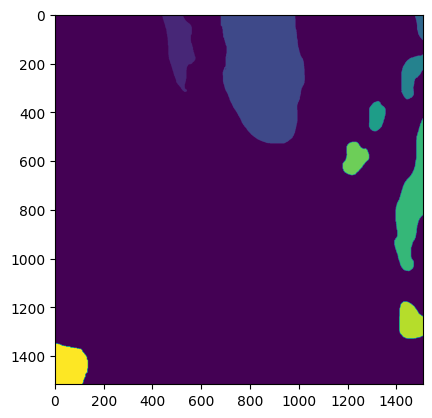

In [30]:
plt.imshow(labels[12])

In [35]:
def splitImg(img, label, tile=1024, stride=512):
    tile_imgs = []
    tile_labels = []
    H, W = label.shape

    x1 = 0
    x2 = tile
    while x1 < W:
        y1 = 0
        y2 = tile
        while y1 < H:
            tile_img = img[y1:y2,x1:x2]
            tile_label = label[y1:y2,x1:x2]

            if len(np.unique(tile_label)) > 1:
                tile_imgs.append(tile_img)
                tile_labels.append(tile_label)
            # print('y:{:}-{:}'.format(y1,y2), 'x:{:}-{:}'.format(x1,x2))

            y1 += stride
            y2 += stride

            if y2 >= H:
                y1, y2 = H-tile, H
                tile_img = img[y1:y2,x1:x2]
                tile_label = label[y1:y2,x1:x2]
                
                if len(np.unique(tile_label)) > 1:
                    tile_imgs.append(tile_img)
                    tile_labels.append(tile_label)
                # print('y:{:}-{:}'.format(y1,y2), 'x:{:}-{:}'.format(x1,x2))
                break

        x1 += stride
        x2 += stride
        
        if x2 >= W:
            y1 = 0
            y2 = tile
            x1, x2 = W - tile, W
            while y1 < H:
                # print('y:{:}-{:}'.format(y1,y2), 'x:{:}-{:}'.format(x1,x2))
                tile_img = img[y1:y2,x1:x2]
                tile_label = label[y1:y2,x1:x2]

                if len(np.unique(tile_label)) > 1:
                    tile_imgs.append(tile_img)
                    tile_labels.append(tile_label)

                y1 += stride
                y2 += stride

                if y2 >= H:
                    y1, y2 = H-tile, H
                    tile_img = img[y1:y2,x1:x2]
                    tile_label = label[y1:y2,x1:x2]

                    if len(np.unique(tile_label)) > 1:
                        tile_imgs.append(tile_img)
                        tile_labels.append(tile_label)
                    # print('y:{:}-{:}'.format(y1,y2), 'x:{:}-{:}'.format(x1,x2))
                    break
            break 
    
    return tile_imgs, tile_labels



In [73]:
origin_dir = '../dataset2d/CRAG'
traimgs_dir = os.path.join(origin_dir, 'train/Images/')
trasegs_dir = os.path.join(origin_dir, 'train/Annotation/')
valimgs_dir = os.path.join(origin_dir, 'valid/Images/')
valsegs_dir = os.path.join(origin_dir, 'valid/Annotation/')

tileimgs_dir = '/dataset/CRAG/images'
tilesegs_dir = '/dataset/CRAG/masks'

imgs = []
segs = []

tra_nms = sorted(['.'.join(nm.split('.')[:-1]) for nm in os.listdir(traimgs_dir)])
val_nms = sorted(['.'.join(nm.split('.')[:-1]) for nm in os.listdir(valimgs_dir)])

for nm in tra_nms:
    img_path = os.path.join(traimgs_dir, nm + '.png')
    seg_path = os.path.join(trasegs_dir, nm + '.png')

    if os.path.isfile(img_path) & os.path.isfile(seg_path):
        imgs.append(img_path)
        segs.append(seg_path)

for nm in val_nms:
    img_path = os.path.join(valimgs_dir, nm + '.png')
    seg_path = os.path.join(valsegs_dir, nm + '.png')

    if os.path.isfile(img_path) & os.path.isfile(seg_path):
        imgs.append(img_path)
        segs.append(seg_path)

files = [{"image": img, "label": seg} for img, seg in zip(imgs, segs)]

for idx, sample in tqdm(enumerate(files), total=len(files)):
    img_path = sample['image']
    label_path = sample['label']
    img = Image.open(img_path)
    label = Image.open(label_path)

    img = np.array(img)
    label = np.array(label)

    if len(img.shape) == 2:
        img = skimage.color.gray2rgb(img)
        print('gray image : ', img_path)
    
    if (len(img.shape) == 3) & (img.shape[-1] == 4):
        img = skimage.color.rgba2rgb(img)
        img = (img * 255).astype(np.uint8)
        print("rgba image : ", img_path)
    
    label = (label > 0).astype(np.uint8)
    nm_base = img_path.split('/')[-1].split('.')[0]
    tile_imgs, tile_labels = splitImg(img, label, tile=800, stride=256)
    tile_id = 0

    break 

  0%|          | 0/213 [00:00<?, ?it/s]


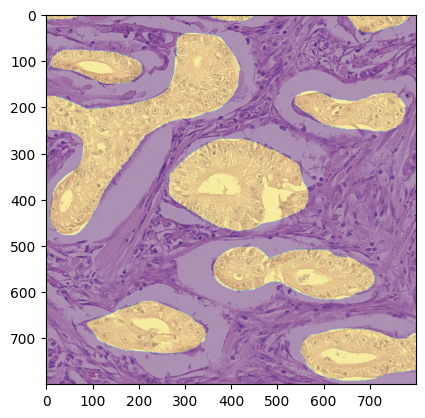

In [83]:
idx = 8
plt.imshow(tile_imgs[idx])
plt.imshow(tile_labels[idx], alpha=0.4)